In [1]:
import glob,os
import scipy.fftpack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statistics
from scipy.stats import pearsonr
from resample import linear_interpl



# customized from https://github.com/scikit-learn/scikit-learn/blob/19d7b1f06/sklearn/metrics/_regression.py#L197
def mean_absolute_percentage_error(y_true, y_pred):
    """Mean absolute percentage error regression loss
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    Returns
    -------
        MAPE output is non-negative floating point. The best value is 0.0.
        But note the fact that bad predictions can lead to arbitarily large
        MAPE values, especially if some y_true values are very close to zero.
        Note that we return a large value instead of `inf` when y_true is zero.
    Examples
    --------
    >>> from sklearn.metrics import mean_absolute_percentage_error
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.3273...
    >>> y_true = [[0.5, 1], [-1, 1], [7, -6]]
    >>> y_pred = [[0, 2], [-1, 2], [8, -5]]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.5515...
    """
    mape = np.abs(y_pred - y_true) / np.abs(y_true)
    output_errors = np.average(mape, axis=0)
    return output_errors


def mean_abs_perc_err(pred, gt):
    return mean_absolute_percentage_error(gt, pred)


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def pca_sensor_xyz_xy(df):
    pca = PCA(n_components=1)
    df[['acc_X_value', 'acc_Y_value', 'acc_Z_value']] -= df[['acc_X_value', 'acc_Y_value', 'acc_Z_value']].mean()
    df['acc_xyz_pca'] = pca.fit_transform( df[['acc_X_value', 'acc_Y_value', 'acc_Z_value']].to_numpy())
    df['acc_xy_pca'] = pca.fit_transform( df[['acc_X_value', 'acc_Y_value']].to_numpy())
    return df


def resample_df(df):
    # df = linear_interpl(df, time_col_header='time_tick', sampling_rate=200)
    df = linear_interpl(df)
    return df


def fruit(path, delay, starttime):
    df = pd.read_csv(path)
#     df = resample_df(df)
#     df = df[(df['time_tick']>(starttime + delay + 6500))&(df['time_tick']<(starttime + delay + 7500))]
    df = pca_sensor_xyz_xy(df)
    t = df['time_tick'].values
    t = (t - t[0])/1000
    x = df['acc_X_value'].values
    y = df['acc_Y_value'].values
    z = df['acc_Z_value'].values
    xyz_pca = df['acc_xyz_pca'].values
    xy_pca = df['acc_xy_pca'].values
    return t, x, y, z, xyz_pca, xy_pca


def fruit_no_load(path, delay, starttime):
    df = pd.read_csv(path)
#     df = resample_df(df)
#     df = df[(df['time_tick']>(starttime + 4000))&(df['time_tick']<(starttime + 5000))]
    df = pca_sensor_xyz_xy(df)
    t = df['time_tick'].values
    t = (t - t[0])/1000
    x = df['acc_X_value'].values
    y = df['acc_Y_value'].values
    z = df['acc_Z_value'].values
    xyz_pca = df['acc_xyz_pca'].values
    xy_pca = df['acc_xy_pca'].values
    return t, x, y, z, xyz_pca, xy_pca

In [2]:
# ===============================================================
apple_path = os.path.abspath('Data/7.2_nexus2_rotate/apple')
tableware_path = os.path.abspath('Data/7.2_nexus2_rotate/tools')
onion_path = os.path.abspath('Data/7.4_nexus2_rotate/onion')
pepper_path = os.path.abspath('Data/7.4_nexus2_rotate/pepper')
# ===============================================================
paths = [apple_path, onion_path, pepper_path, tableware_path]
weights_all = []
intensity_load_all = []
intensity_no_load_all = []

In [3]:
from pathlib import Path

for path in paths:
    # validation is 'LOOCV'
    # TODO: can use function to get the info from counting files
    if path == apple_path:
        n_splits = 24
    elif path == tableware_path:
        n_splits = 6
    elif path == pepper_path:
        n_splits = 6
    elif path == onion_path:
        n_splits = 16
    else:
        print('error!')
        exit()

    os.chdir(path)
#     print('path:', path)
#     print('n_splits:', n_splits)
    
    weights = []
    intensity_load = []
    intensity_no_load = []
    for counter, current_file in enumerate(glob.glob("*.csv")):
        param = current_file.split('_')
        # print(os.path.join(path, current_file))
        tf, xf, yf, zf, xyz_pcaf, xy_pcaf = fruit(os.path.join(path, current_file) ,int(param[4]),int(param[3]))
        
        weights.append(int(param[2]))

        te, xe, ye, ze, xyz_pcae, xy_pcae = fruit_no_load(current_file,int(param[4]),int(param[3]))
        # ======================================
        # y-axis: MAE = 12.7
        # ========================================
        yf -= np.mean(yf)
        intense_f = np.mean(np.abs(yf))
        # print("{} {} {} {}:{:.6f}\n".format(param[0],param[1],param[2], param[3],intense))
        intensity_load.append(intense_f)
        ye -= np.mean(ye)
        intense_e = np.mean(np.abs(ye))
        intensity_no_load.append(intense_e)
        
    
    intensity_net = np.asarray(intensity_no_load) - np.asarray(intensity_load)
    data = pd.DataFrame({'weights': weights, 'intensity_net': intensity_net})
    data = data.sort_values('intensity_net')
    # print(data)
    X = data['intensity_net'].values
    y = data['weights'].values

    kf = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    kf.get_n_splits(X, y)

    final_GT_list = []
    final_pred_list = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index].reshape(-1, 1), X[test_index].reshape(-1, 1)
        y_train, y_test = y[train_index], y[test_index]
        reg = LinearRegression().fit(X_train, y_train)
        pred = reg.predict(X_test)
        final_GT_list.append(y_test)
        final_pred_list.append(pred)
        
    pred = np.hstack(final_pred_list)
    gt = np.hstack(final_GT_list)
    print("pred: ", pred)
    print("actual: ", gt)
#     print('total number:', len(gt))
#     print('min/max weight (GT):', np.min(gt), np.max(gt))
#     print("MAE (mean absolute error) is: ", mean_absolute_error(pred, gt))
#     print("Mean absolute percentage error", mean_abs_perc_err(pred, gt))
#     print("\n\n")
    
    weights_all += weights
    intensity_load_all += intensity_load
    intensity_no_load_all += intensity_no_load

pred:  [163.95652174 160.7826087  161.30434783 162.73913043 161.69565217
 163.95652174 163.65217391 161.73913043 160.52173913 162.08695652
 162.04347826 162.86956522 160.56521739 161.39130435 162.86956522
 160.73913043 164.34782609 161.82608696 161.7826087  162.82608696
 163.86956522 161.73913043 163.08695652 161.60869565]
actual:  [123 196 184 151 175 123 130 174 202 166 167 148 201 182 148 197 114 172
 173 149 125 174 143 177]
pred:  [147.53333333 145.66666667 147.26666667 146.6        146.53333333
 150.53333333 151.26666667 145.8        129.73333333 136.06666667
 135.2        148.4        146.26666667 147.93333333 149.2
 148.        ]
actual:  [109 137 113 123 124  64  53 135 376 281 294  96 128 103  84 102]
pred:  [134.  143.2 139.8 139.  139.  139. ]
actual:  [164 118 135 139 139 139]
pred:  [179.6 177.  202.  177.6 194.  217.8]
actual:  [250 263 138 260 178  59]


In [4]:
print(len(weights_all))
print(len(intensity_load_all))
print(len(intensity_no_load_all))

52
52
52


In [5]:
intensity_net_all = np.asarray(intensity_no_load_all) - np.asarray(intensity_load_all)
data_all = pd.DataFrame({'weights': weights_all, 'intensity_net': intensity_net_all})
data_all = data_all.sort_values('intensity_net')
X = data_all['intensity_net'].values
y = data_all['weights'].values

print("Pearson correlation coefficient: ", pearsonr(X, y))

kf = KFold(n_splits=len(weights_all), random_state=1, shuffle=True)
kf.get_n_splits(X, y)
final_GT_list = []
final_pred_list = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index].reshape(-1, 1), X[test_index].reshape(-1, 1)
    y_train, y_test = y[train_index], y[test_index]
    reg = LinearRegression().fit(X_train, y_train)
    # print(reg.score(X_train, y_train), reg.coef_)
    final_GT_list.append(y_test)
    final_pred_list.append(reg.predict(X_test))

pred = np.hstack(final_pred_list)
gt = np.hstack(final_GT_list)
# print('average weights (GT):', np.mean(gt))
print('objects:',paths)
print('total number:', len(gt))
print('min/max weight (GT):', np.min(gt), np.max(gt))
# print("rms error is: " + str(rmse(pred, gt)))
print("MAE (mean absolute error) is: ", mean_absolute_error(pred, gt))
print("Mean absolute percentage error", mean_abs_perc_err(pred, gt))

Pearson correlation coefficient:  (nan, nan)
objects: ['C:\\Users\\nili266\\OneDrive\\Spring2023\\CS4605\\GroupProject\\vibroscale\\code\\Data\\7.2_nexus2_rotate\\apple', 'C:\\Users\\nili266\\OneDrive\\Spring2023\\CS4605\\GroupProject\\vibroscale\\code\\Data\\7.4_nexus2_rotate\\onion', 'C:\\Users\\nili266\\OneDrive\\Spring2023\\CS4605\\GroupProject\\vibroscale\\code\\Data\\7.4_nexus2_rotate\\pepper', 'C:\\Users\\nili266\\OneDrive\\Spring2023\\CS4605\\GroupProject\\vibroscale\\code\\Data\\7.2_nexus2_rotate\\tools']
total number: 52
min/max weight (GT): 53 376
MAE (mean absolute error) is:  44.61236802413272
Mean absolute percentage error 0.3340538832355299


C:\Users\nili266\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


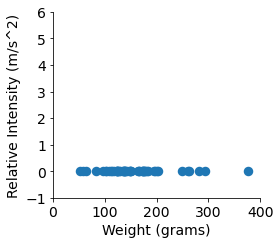

In [6]:
fig = plt.figure(figsize=(4,3.5))
ax = fig.add_subplot(1,1,1)
ax.scatter(weights_all, intensity_net_all,linewidths=3.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Relative Intensity (m/s^2)", fontsize=14)
plt.xlabel("Weight (grams)", fontsize=14)
plt.margins(0,0, tight=True)
plt.xlim(0,400)
plt.xticks([0, 100, 200, 300, 400])
plt.ylim(-1,6)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()

In [7]:
intensity_no_load_all

[2.8102396108069243,
 3.066311208557362,
 3.1716502429079614,
 3.1411648617293566,
 3.1028599547602402,
 3.688192670132466,
 3.2087000938583228,
 3.851963439323965,
 3.1730900115293594,
 3.806765903593671,
 3.4698418967820857,
 3.3197997260382337,
 3.4378342977542853,
 3.684549485472911,
 3.5569820407207744,
 3.7218806060360006,
 3.1418371741546576,
 3.0926341500278096,
 3.0655756103615532,
 3.272598233169778,
 3.573464627127217,
 3.066267136604391,
 2.9063419508330823,
 2.881927789944083,
 2.4604302704163152,
 3.4214340174046898,
 3.7247731465779292,
 3.3178731803932444,
 4.198035649712665,
 3.935104368353305,
 3.0479447333650946,
 3.950951910933056,
 3.06591910540701,
 3.6299461374776336,
 4.073269837656061,
 3.6896017056522963,
 3.9520707301743263,
 3.675849017567059,
 2.6051640367942324,
 3.043636055271778,
 5.0551117205474485,
 4.673454812741731,
 4.320942723149125,
 4.01828226716848,
 3.3339936049459276,
 3.9282932954971104,
 3.0539916687761437,
 2.9052284882104034,
 3.0032184555

In [8]:
intensity_load_all

[2.8102396108069243,
 3.066311208557362,
 3.1716502429079614,
 3.1411648617293566,
 3.1028599547602402,
 3.688192670132466,
 3.2087000938583228,
 3.851963439323965,
 3.1730900115293594,
 3.806765903593671,
 3.4698418967820857,
 3.3197997260382337,
 3.4378342977542853,
 3.684549485472911,
 3.5569820407207744,
 3.7218806060360006,
 3.1418371741546576,
 3.0926341500278096,
 3.0655756103615532,
 3.272598233169778,
 3.573464627127217,
 3.066267136604391,
 2.9063419508330823,
 2.881927789944083,
 2.4604302704163152,
 3.4214340174046898,
 3.7247731465779292,
 3.3178731803932444,
 4.198035649712665,
 3.935104368353305,
 3.0479447333650946,
 3.950951910933056,
 3.06591910540701,
 3.6299461374776336,
 4.073269837656061,
 3.6896017056522963,
 3.9520707301743263,
 3.675849017567059,
 2.6051640367942324,
 3.043636055271778,
 5.0551117205474485,
 4.673454812741731,
 4.320942723149125,
 4.01828226716848,
 3.3339936049459276,
 3.9282932954971104,
 3.0539916687761437,
 2.9052284882104034,
 3.0032184555